In [ ]:
imporimportt numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

window_size = 24
target_col = 'PM2.5'
station_name = 'Aotizhongxin'
max_epochs = 30

In [ ]:
data_path = "/kaggle/input/datasets/akashbhavanisankar/beijing-air-quality-data/Beijing Multisite air Quality data.csv"

df = pd.read_csv(data_path)
print("raw shape:", df.shape)
print(df.head())
print(df.columns)

raw shape: (420768, 17)
   year  month  day  hour  PM2.5  PM10   SO2   NO2     CO    O3  TEMP    PRES  \
0  2013      3    1     0    4.0   4.0   4.0   7.0  300.0  77.0  -0.7  1023.0   
1  2013      3    1     1    8.0   8.0   4.0   7.0  300.0  77.0  -1.1  1023.2   
2  2013      3    1     2    7.0   7.0   5.0  10.0  300.0  73.0  -1.1  1023.5   
3  2013      3    1     3    6.0   6.0  11.0  11.0  300.0  72.0  -1.4  1024.5   
4  2013      3    1     4    3.0   3.0  12.0  12.0  300.0  72.0  -2.0  1025.2   

   DEWP  RAIN   wd  WSPM       station  
0 -18.8   0.0  NNW   4.4  Aotizhongxin  
1 -18.2   0.0    N   4.7  Aotizhongxin  
2 -18.2   0.0  NNW   5.6  Aotizhongxin  
3 -19.4   0.0   NW   3.1  Aotizhongxin  
4 -19.5   0.0    N   2.0  Aotizhongxin  
Index(['year', 'month', 'day', 'hour', 'PM2.5', 'PM10', 'SO2', 'NO2', 'CO',
       'O3', 'TEMP', 'PRES', 'DEWP', 'RAIN', 'wd', 'WSPM', 'station'],
      dtype='object')


In [ ]:
# checking available stations in the dataset
print("stations:", df['station'].unique())
df_station = df[df['station'] == station_name].copy()
df_station['datetime'] = pd.to_datetime(df_station[['year', 'month', 'day', 'hour']])
df_station = df_station.sort_values('datetime').reset_index(drop=True)

# keeping only 2016 and 2017 for code simplicity
df_sub = df_station[(df_station['year'] >= 2016) & (df_station['year'] <= 2017)].copy()
print("subset 2016-2017 for", station_name, "shape:", df_sub.shape)
df_sub[['datetime', 'PM2.5']].head()


stations: ['Aotizhongxin' 'Changping' 'Dingling' 'Dongsi' 'Guanyuan' 'Gucheng'
 'Huairou' 'Nongzhanguan' 'Shunyi' 'Tiantan' 'Wanliu' 'Wanshouxigong']
subset 2016-2017 for Aotizhongxin shape: (10200, 18)


,datetime,PM2.5
24864,2016-01-01 00:00:00,209.0
24865,2016-01-01 01:00:00,211.0
24866,2016-01-01 02:00:00,167.0
24867,2016-01-01 03:00:00,136.0
24868,2016-01-01 04:00:00,108.0


In [ ]:
df_sub[['datetime', 'PM2.5']]

,datetime,PM2.5
24864,2016-01-01 00:00:00,209.0
24865,2016-01-01 01:00:00,211.0
24866,2016-01-01 02:00:00,167.0
24867,2016-01-01 03:00:00,136.0
24868,2016-01-01 04:00:00,108.0
...,...,...
35059,2017-02-28 19:00:00,12.0
35060,2017-02-28 20:00:00,13.0
35061,2017-02-28 21:00:00,16.0
35062,2017-02-28 22:00:00,21.0


In [ ]:
df_sub = df_sub.replace('NA', np.nan)
df_sub = df_sub.replace('NaN', np.nan)

for col in df_sub.columns:
    if col not in ['wd', 'station', 'datetime']:
        df_sub[col] = pd.to_numeric(df_sub[col], errors='coerce')

numeric_cols = df_sub.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
df_sub[numeric_cols] = df_sub[numeric_cols].interpolate(method='linear', limit_direction='both')
df_sub = df_sub.dropna().reset_index(drop=True)
print("after interpolation & dropna:", df_sub.shape)

after interpolation & dropna: (10128, 18)


In [ ]:
df_sub['wd'] = df_sub['wd'].astype('category')
wd_dummies = pd.get_dummies(df_sub['wd'], prefix='wd')
print("wind direction categories:", df_sub['wd'].cat.categories)

wind direction categories: Index(['E', 'ENE', 'ESE', 'N', 'NE', 'NNE', 'NNW', 'NW', 'S', 'SE', 'SSE',
       'SSW', 'SW', 'W', 'WNW', 'WSW'],
      dtype='object')


In [ ]:
feature_cols_numeric = ['PM2.5','PM10','SO2','NO2','CO','O3','TEMP','PRES','DEWP','RAIN','WSPM']
df_features = pd.concat([df_sub[feature_cols_numeric],wd_dummies], axis=1)
print("feature dataframe shape:", df_features.shape)
print(df_features.head())

feature dataframe shape: (10128, 27)
   PM2.5   PM10   SO2    NO2      CO    O3  TEMP    PRES  DEWP  RAIN  ...  \
0  209.0  268.0  47.0  123.0  5300.0  13.0  -2.5  1024.5  -8.2   0.0  ...   
1  211.0  248.0  66.0  119.0  5400.0  16.0  -3.5  1023.8  -7.3   0.0  ...   
2  167.0  192.0  64.0  115.0  4300.0  12.0  -4.7  1023.7  -7.3   0.0  ...   
3  136.0  159.0  56.0  111.0  4100.0   9.0  -3.6  1023.1  -7.7   0.0  ...   
4  108.0  121.0  46.0  107.0  3600.0   7.0  -5.1  1022.3  -7.7   0.0  ...   

   wd_NNW  wd_NW   wd_S  wd_SE  wd_SSE  wd_SSW  wd_SW   wd_W  wd_WNW  wd_WSW  
0   False  False  False  False   False   False  False  False   False   False  
1   False  False  False  False   False   False  False  False   False   False  
2   False  False  False  False   False   False  False  False   False   False  
3   False  False  False  False   False   False  False  False   False   False  
4   False  False  False  False   False   False  False  False   False   False  

[5 rows x 27 columns]


In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_features.values)
feature_names = df_features.columns.tolist()
target_index = feature_names.index(target_col)
print("number of features:", len(feature_names))
print("target index:", target_index)

number of features: 27
target index: 0


In [ ]:
def create_sequences(data, window_size, target_index):
    x, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:i+window_size]
        target = data[i+window_size, target_index]
        x.append(window)
        y.append(target)
    return np.array(x), np.array(y)

x_all, y_all = create_sequences(data_scaled, window_size, target_index)
print("x_all shape:", x_all.shape)
print("y_all shape:", y_all.shape)

x_all shape: (10104, 24, 27)
y_all shape: (10104,)


In [ ]:
n_samples = x_all.shape[0]
train_size = int(n_samples * 0.7)
val_size   = int(n_samples * 0.15)
test_size  = n_samples - train_size - val_size

x_train = x_all[:train_size]
y_train = y_all[:train_size]
x_val   = x_all[train_size:train_size+val_size]
y_val   = y_all[train_size:train_size+val_size]
x_test  = x_all[train_size+val_size:]
y_test  = y_all[train_size+val_size:]

print("train:", x_train.shape, "val:", x_val.shape, "test:", x_test.shape)

train: (7072, 24, 27) val: (1515, 24, 27) test: (1517, 24, 27)


In [ ]:
n_timesteps = x_train.shape[1]
n_features = x_train.shape[2]

def build_lstm_baseline(timesteps, features):
    model = Sequential([LSTM(64, input_shape=(timesteps, features)),Dense(32, activation='relu'),Dense(1)])
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['mae'])
    return model

def build_lstm_stacked(timesteps, features):
    model = Sequential([LSTM(64,return_sequences=True,input_shape=(timesteps, features)),
        Dropout(0.2),LSTM(32),Dense(16, activation='relu'),Dense(1)])
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),metrics=['mae'])
    return model

model_a = build_lstm_baseline(n_timesteps, n_features)
model_b = build_lstm_stacked(n_timesteps, n_features)

model_a.summary()
model_b.summary()

2026-02-22 11:48:07.711219: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,665 (100.25 KB)

 Trainable params: 25,665 (100.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 24, 64)         │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,513 (142.63 KB)

 Trainable params: 36,513 (142.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)
# model a: baseline LSTM
history_a = model_a.fit(x_train, y_train,epochs=max_epochs,
    batch_size=32,validation_data=(x_val, y_val),callbacks=[early_stop],verbose=1)
test_loss_a, test_mae_a = model_a.evaluate(x_test, y_test, verbose=0)
print("model a (baseline) - test mse:", test_loss_a, "test mae:", test_mae_a)
# model b: stacked LSTM
history_b = model_b.fit(x_train, y_train,epochs=max_epochs,
    batch_size=32,validation_data=(x_val, y_val),callbacks=[early_stop],verbose=1)
test_loss_b, test_mae_b = model_b.evaluate(x_test, y_test, verbose=0)
print("model b (stacked) - test mse:", test_loss_b, "test mae:", test_mae_b)

Epoch 1/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0027 - mae: 0.0351 - val_loss: 0.0012 - val_mae: 0.0236
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 9.0176e-04 - mae: 0.0186 - val_loss: 9.8189e-04 - val_mae: 0.0217
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 7.3098e-04 - mae: 0.0167 - val_loss: 8.4818e-04 - val_mae: 0.0199
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 6.2530e-04 - mae: 0.0154 - val_loss: 7.7133e-04 - val_mae: 0.0189
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 5.4863e-04 - mae: 0.0144 - val_loss: 7.2721e-04 - val_mae: 0.0181
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.9917e-04 - mae: 0.0137 - val_loss: 6.9433e-04 - val_mae: 0.0175
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.6863e-04 - mae: 0.0132 - val_loss: 6.7451e-04 - val_mae: 0.0172
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.3382e-04 - mae: 0.0128 - val_loss: 6.6352e-04 - val_mae:

In [ ]:
meteo_cols = ['TEMP', 'PRES', 'DEWP', 'RAIN', 'WSPM']
feature_cols_ablation = [c for c in feature_names if c not in meteo_cols]
df_ablation = df_features[feature_cols_ablation].copy()
print("ablation feature shape:", df_ablation.shape)
print("ablation features:", df_ablation.columns.tolist())

scaler_ab = MinMaxScaler()
data_scaled_ab = scaler_ab.fit_transform(df_ablation.values)
feature_names_ab = df_ablation.columns.tolist()
target_index_ab = feature_names_ab.index(target_col)

x_ab, y_ab = create_sequences(data_scaled_ab, window_size, target_index_ab)
print("ablation x shape:", x_ab.shape, "y shape:", y_ab.shape)

ablation feature shape: (10128, 22)
ablation features: ['PM2.5', 'PM10', 'SO2', 'NO2', 'CO', 'O3', 'wd_E', 'wd_ENE', 'wd_ESE', 'wd_N', 'wd_NE', 'wd_NNE', 'wd_NNW', 'wd_NW', 'wd_S', 'wd_SE', 'wd_SSE', 'wd_SSW', 'wd_SW', 'wd_W', 'wd_WNW', 'wd_WSW']
ablation x shape: (10104, 24, 22) y shape: (10104,)


In [ ]:
n_samples_ab = x_ab.shape[0]
train_size_ab = int(n_samples_ab * 0.7)
val_size_ab   = int(n_samples_ab * 0.15)

x_train_ab = x_ab[:train_size_ab]
y_train_ab = y_ab[:train_size_ab]
x_val_ab   = x_ab[train_size_ab:train_size_ab+val_size_ab]
y_val_ab   = y_ab[train_size_ab:train_size_ab+val_size_ab]
x_test_ab  = x_ab[train_size_ab+val_size_ab:]
y_test_ab  = y_ab[train_size_ab+val_size_ab:]

n_features_ab = x_train_ab.shape[2]
print("ablation train/val/test:", x_train_ab.shape, x_val_ab.shape, x_test_ab.shape)

ablation train/val/test: (7072, 24, 22) (1515, 24, 22) (1517, 24, 22)


In [ ]:
model_ab = build_lstm_baseline(window_size, n_features_ab)
history_ab = model_ab.fit(x_train_ab, y_train_ab,epochs=max_epochs,
    batch_size=32,validation_data=(x_val_ab, y_val_ab),callbacks=[early_stop],verbose=1)
test_loss_ab, test_mae_ab = model_ab.evaluate(x_test_ab, y_test_ab, verbose=0)
print("ablation (no meteo) - test mse:", test_loss_ab, "test mae:", test_mae_ab)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0029 - mae: 0.0359 - val_loss: 0.0013 - val_mae: 0.0250
Epoch 2/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 9.4266e-04 - mae: 0.0197 - val_loss: 0.0013 - val_mae: 0.0252
Epoch 3/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 7.3084e-04 - mae: 0.0173 - val_loss: 0.0012 - val_mae: 0.0244
Epoch 4/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 6.3318e-04 - mae: 0.0160 - val_loss: 0.0012 - val_mae: 0.0241
Epoch 5/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.7391e-04 - mae: 0.0152 - val_loss: 0.0012 - val_mae: 0.0238
Epoch 6/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 5.2712e-04 - mae: 0.0143 - val_loss: 0.0011 - val_mae: 0.0228
Epoch 7/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.9329e-04 - mae: 0.0138 - val_loss: 9.7467e-04 - val_mae: 0.0217
Epoch 8/30
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.6740e-04 - mae: 0.0134 - val_loss: 8.7133e-04 - val_mae: 0.0203
Epoch 9/30
221/221 ━━━━

In [ ]:
baseline_mse = test_loss_a
baseline_mae = test_mae_a
stacked_mse = test_loss_b
stacked_mae = test_mae_b
ablation_mse = test_loss_ab
ablation_mae = test_mae_ab

results_df = pd.DataFrame({'model': ['baseline_lstm', 'stacked_lstm', 'ablation_no_meteo'],
    'test_mse': [baseline_mse, stacked_mse, ablation_mse],
    'test_mae': [baseline_mae, stacked_mae, ablation_mae]})
results_df


,model,test_mse,test_mae
0,baseline_lstm,0.000951,0.017068
1,stacked_lstm,0.000998,0.017926
2,ablation_no_meteo,0.000937,0.017129


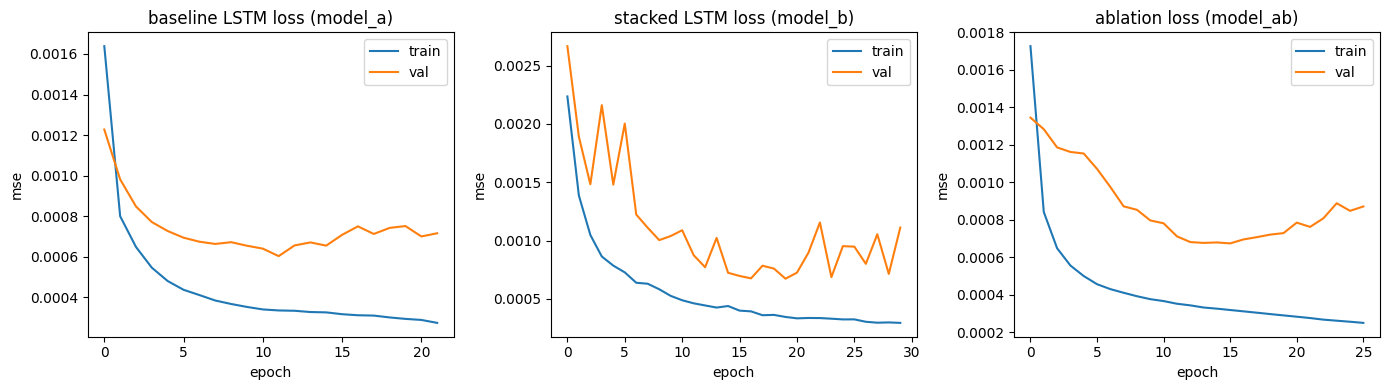

In [ ]:
plt.figure(figsize=(14,4))

# baseline LSTM(model_a)
plt.subplot(1,3,1)
plt.plot(history_a.history['loss'], label='train')
plt.plot(history_a.history['val_loss'], label='val')
plt.title('baseline LSTM loss (model_a)')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

# stacked LSTM(model_b)
plt.subplot(1,3,2)
plt.plot(history_b.history['loss'], label='train')
plt.plot(history_b.history['val_loss'], label='val')
plt.title('stacked LSTM loss (model_b)')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

# ablation LSTM(model_ab)
plt.subplot(1,3,3)
plt.plot(history_ab.history['loss'], label='train')
plt.plot(history_ab.history['val_loss'], label='val')
plt.title('ablation loss (model_ab)')
plt.xlabel('epoch')
plt.ylabel('mse')
plt.legend()

plt.tight_layout()
plt.show()

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


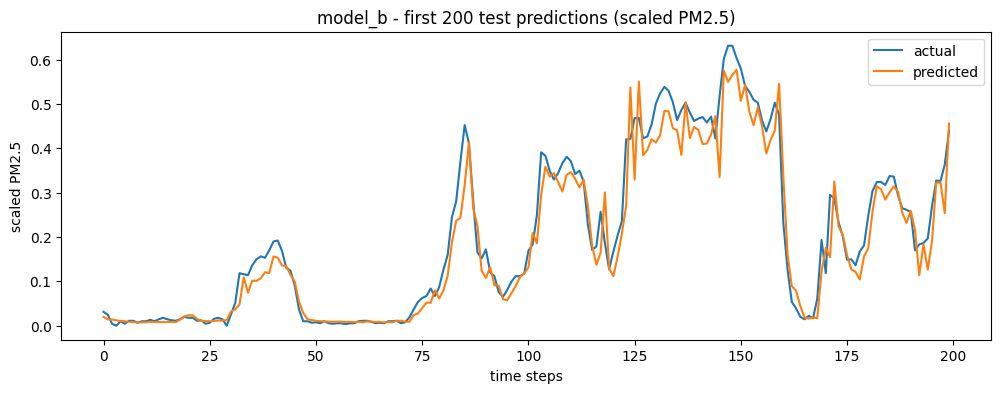

In [ ]:
# Using stacked LSTM as the best model(model_b)
best_model = model_b
y_pred = best_model.predict(x_test).flatten()

plt.figure(figsize=(12,4))
plt.plot(y_test[:200], label='actual')
plt.plot(y_pred[:200], label='predicted')
plt.title('model_b - first 200 test predictions (scaled PM2.5)')
plt.xlabel('time steps')
plt.ylabel('scaled PM2.5')
plt.legend()
plt.show()

mean abs error (scaled): 0.0179259470482457
max abs error (scaled): 0.3251477681724718


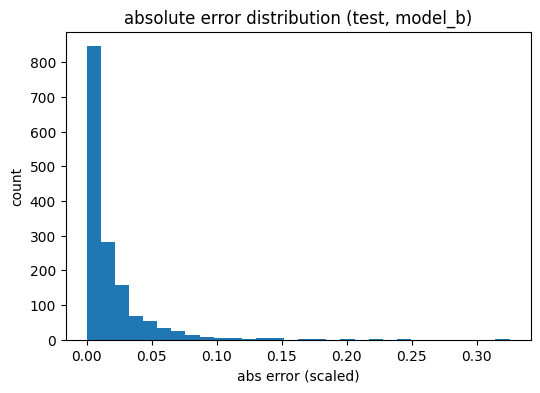

,index,actual_scaled,pred_scaled,abs_error_scaled
0,755,0.640223,0.315076,0.325148
1,759,0.793296,0.547359,0.245937
2,1196,0.000000,0.222192,0.222192
3,940,0.088268,0.283359,0.195091
4,757,0.724022,0.540157,0.183865
5,145,0.517318,0.335230,0.182088
6,215,0.368715,0.538945,0.170230
7,123,0.420112,0.269937,0.150175
8,762,0.424581,0.274481,0.150100
9,1199,0.279330,0.129564,0.149766


In [ ]:
errors = y_pred - y_test
abs_errors = np.abs(errors)
print("mean abs error (scaled):", abs_errors.mean())
print("max abs error (scaled):", abs_errors.max())

plt.figure(figsize=(6,4))
plt.hist(abs_errors, bins=30)
plt.title('absolute error distribution (test, model_b)')
plt.xlabel('abs error (scaled)')
plt.ylabel('count')
plt.show()

# showing indices of worst n errors
n_worst = 10
worst_idx = np.argsort(-abs_errors)[:n_worst]
worst_cases = pd.DataFrame({'index': worst_idx,
    'actual_scaled': y_test[worst_idx],
    'pred_scaled': y_pred[worst_idx],
    'abs_error_scaled': abs_errors[worst_idx]}).sort_values('abs_error_scaled', ascending=False)

worst_cases


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

y_test_2d = np.zeros((len(y_test), scaler.n_features_in_))
y_pred_2d = np.zeros((len(y_pred), scaler.n_features_in_))
y_test_2d[:, target_index] = y_test
y_pred_2d[:, target_index] = y_pred

inv_test = scaler.inverse_transform(y_test_2d)[:, target_index]
inv_pred = scaler.inverse_transform(y_pred_2d)[:, target_index]

orig_mse = mean_squared_error(inv_test, inv_pred)
orig_mae = mean_absolute_error(inv_test, inv_pred)
orig_rmse = np.sqrt(orig_mse)
print("model_b - test MAE (original PM2.5 units):", orig_mae)
print("model_b - test RMSE (original PM2.5 units):", orig_rmse)

model_b - test MAE (original PM2.5 units): 16.043722608179905
model_b - test RMSE (original PM2.5 units): 28.279972394155095


In [ ]:
comparison_df = results_df.copy()
comparison_df['mse_delta_vs_baseline'] = comparison_df['test_mse'] - baseline_mse
comparison_df['mae_delta_vs_baseline'] = comparison_df['test_mae'] - baseline_mae
comparison_df

,model,test_mse,test_mae,mse_delta_vs_baseline,mae_delta_vs_baseline
0,baseline_lstm,0.000951,0.017068,0.000000,0.000000
1,stacked_lstm,0.000998,0.017926,0.000048,0.000858
2,ablation_no_meteo,0.000937,0.017129,-0.000014,0.000060
